```bash
by: arjuna
course: cpsc322, fall 2024
project: premier league match prediction
```





This project aims to predict the outcomes of Premier League matchups based on historical data from past seasons. The dataset, scraped **[2]** from [fbref.com](https://fbref.com/), contains match data for over 2,281 games, including various attributes relevant to each game, such as team statistics, venues, formations, and match outcomes. I specifically scraped for seasons 2021-24, as my team was dominant during these seasons. This also gave a guaranteed winning team, which came in helpful when testing to see if my classifier was actually making the right prediction on two teams.


My dataset for this project contained 2242 instances of match data gathered above. The full list of attributes can be found in the project introduction in project root `README.md`. Here are the important attributes for this classification task:
* xg: expeceted goals **[1]**
* xga: expected goals against **[1]**
* ga, gf: goals against/goals for
* poss: possesion of the ball 
* sh, sot: shots taken/shots on target
* fk: free kicks awarded
* pk, pkatt: pentaly kicks conceded/penalty kicks taken

These attributes are very important when trying to predict a winner, a team that shoots the ball and scores more is most likely going to beat a team with a low possession statistic etc. Let's visualize some of these statistics to compare Premier League teams to get an idea of who the strong performers are.

---

```bash
import required libraries
read in the data
```

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

data = pd.read_csv('../data/premier_league_data2021-24.csv').iloc[: , 1:]
data.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,2023-08-11,20:00,Premier League,Matchweek 1,Fri,Away,W,3,0,Burnley,...,Match Report,NaN,17.0,8.0,13.9,0.0,0,0,2023,Manchester City
1,2023-08-19,20:00,Premier League,Matchweek 2,Sat,Home,W,1,0,Newcastle United,...,Match Report,NaN,14.0,4.0,17.9,0.0,0,0,2023,Manchester City
2,2023-08-27,14:00,Premier League,Matchweek 3,Sun,Away,W,2,1,Sheffield United,...,Match Report,NaN,29.0,9.0,17.3,2.0,0,1,2023,Manchester City
3,2023-09-02,15:00,Premier League,Matchweek 4,Sat,Home,W,5,1,Fulham,...,Match Report,NaN,6.0,4.0,14.8,0.0,1,1,2023,Manchester City
4,2023-09-16,15:00,Premier League,Matchweek 5,Sat,Away,W,3,1,West Ham,...,Match Report,NaN,29.0,13.0,16.4,1.0,0,0,2023,Manchester City


---

```bash
calculate team average goals, create plot
```

In [ ]:
team_avg_goals = data.groupby('team')['gf'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='team', y='gf', data=team_avg_goals, palette='muted')
plt.title('Average Goals Scored (gf) by Team')
plt.xlabel('Team')
plt.ylabel('Average Goals Scored')
plt.xticks(rotation=45, ha='right')
plt.suptitle('Figure 1: Goals Scored', fontsize=20, weight='bold', y=1.02)
plt.show()


ValueError: 'Grays' is not a valid palette name

<Figure size 1200x600 with 0 Axes>

We see here in **Figure** 1 that Manchester City leads the league in average goals scored per game, followed closely by Arsenal and Liverpool. Norwich City can be seen to stuggle to score goals consistently. \
\
This stat helps identify the teams with the strongest offence, but it's also important to check each teams goals conceded, defense wins games as well.

---

```bash
calculate team average goals against, create plot
```

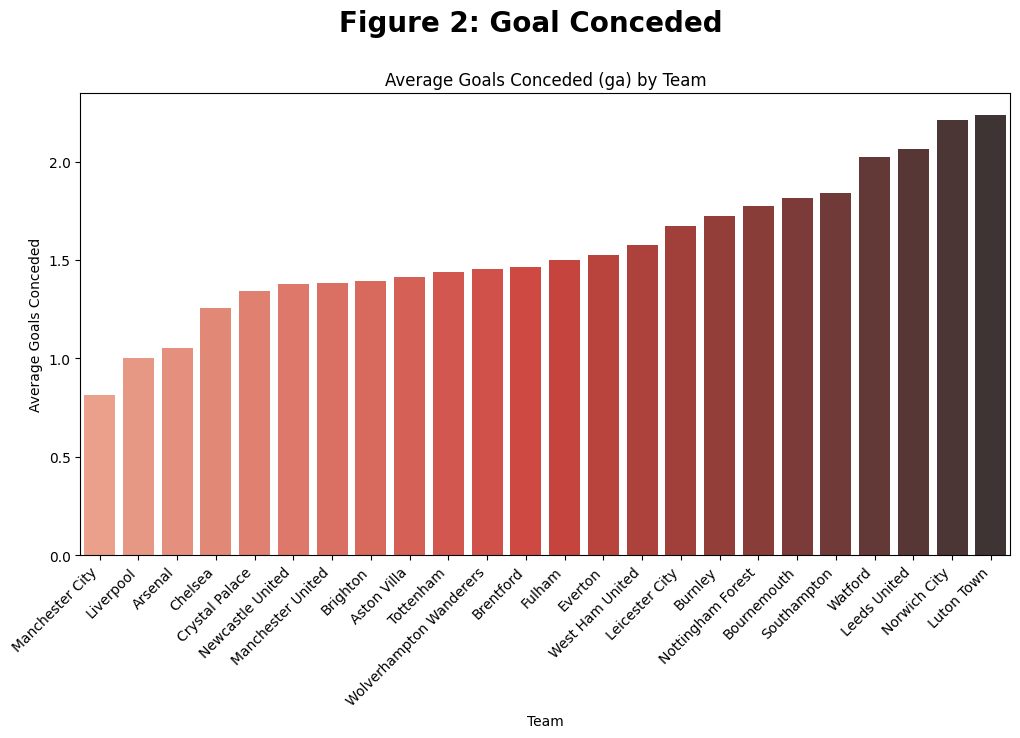

In [19]:
team_avg_goals_conceded = data.groupby('team')['ga'].mean().sort_values().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='team', y='ga', data=team_avg_goals_conceded, palette='Reds_d')
plt.title('Average Goals Conceded (ga) by Team')
plt.xlabel('Team')
plt.ylabel('Average Goals Conceded')
plt.xticks(rotation=45, ha='right')
plt.suptitle('Figure 2: Goal Conceded', fontsize=20, weight='bold', y=1.02)
plt.show()


Again, **Figure 2** shows us that Manchester City have the strongest defense in our data as well. We also see Liverpool and Arsenal in the top 3, similarly to the graph above comparing goals scored per game. \
\
The easiest way to compare the teams in our data and find who the strongest competitor would be to just compare teams based on their average win/loss rate.

---

```bash
calculate team win/loss rate, create plot
```

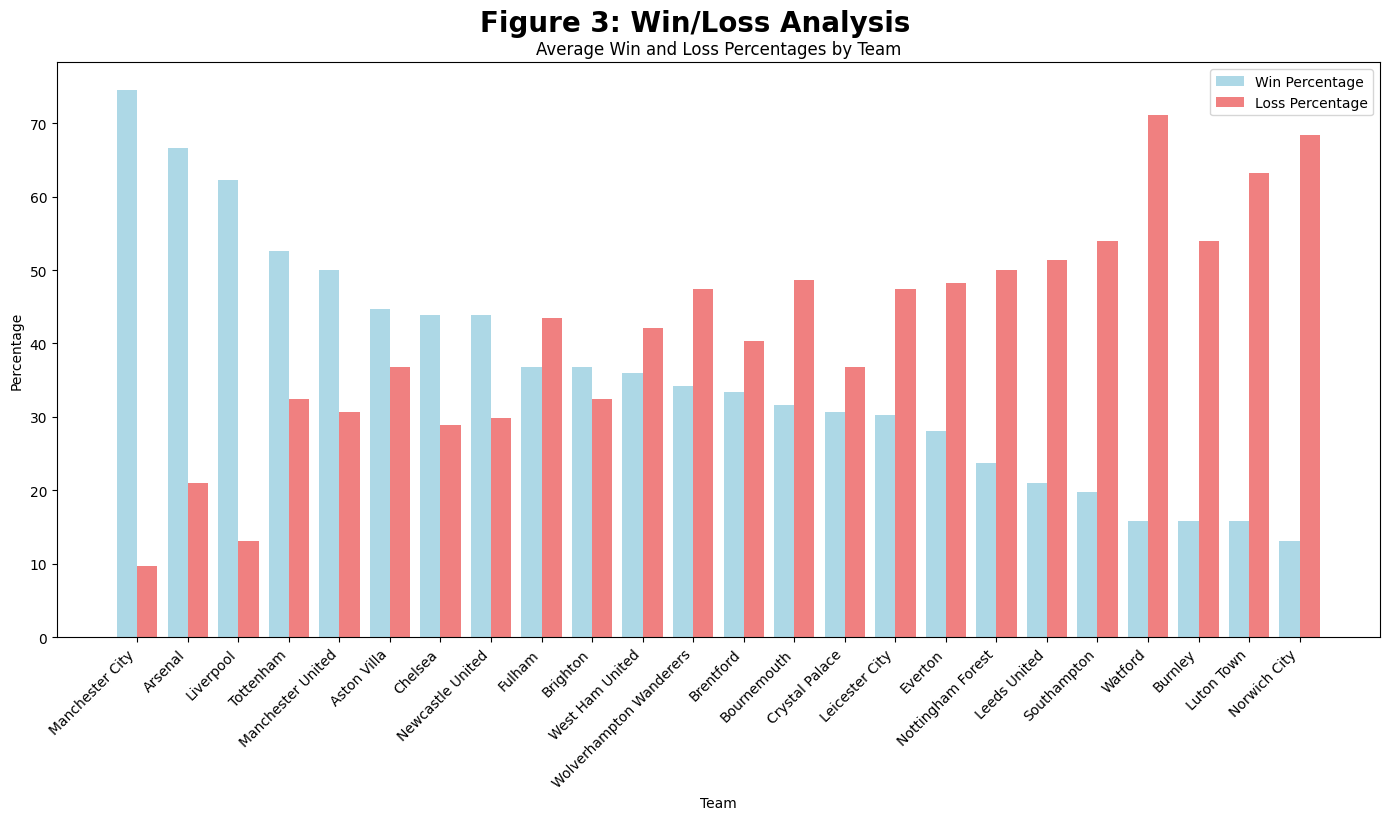

In [18]:
team_results = data.groupby('team')['result'].value_counts(normalize=True).unstack().fillna(0)
team_results['win_percentage'] = team_results['W'] * 100
team_results['loss_percentage'] = team_results['L'] * 100

team_results_sorted = team_results.sort_values(by='win_percentage', ascending=False).reset_index()

plt.figure(figsize=(14, 8))
bar_width = 0.4
x = np.arange(len(team_results_sorted['team']))

plt.bar(x - bar_width / 2, team_results_sorted['win_percentage'], width=bar_width, label='Win Percentage', color='lightblue')
plt.bar(x + bar_width / 2, team_results_sorted['loss_percentage'], width=bar_width, label='Loss Percentage', color='lightcoral')

plt.xticks(x, team_results_sorted['team'], rotation=45, ha='right')
plt.title('Average Win and Loss Percentages by Team')
plt.xlabel('Team')
plt.ylabel('Percentage')
plt.legend()
plt.tight_layout()
plt.suptitle('Figure 3: Win/Loss Analysis', fontsize=20, weight='bold', y=1.02)
plt.show()

Okay, so **Figure 3** gives us a pretty good idea of what teams will be predicted as winners more often. Teams with a higher win percentage, shown to the left of **Figure 3** will definitely win against the teams to the right of the graph. \
\
Now that we've taken a better look at the data I used for this project, let's jump into my classification strategy.

---

```bash
my classifiers
```

I chose to implement 3 classifiers for this prediction task:
1. random forest
2. k-nearest neighbors
3. decision tree

For my random forest classifier, I based my implementation off previous utility functions from CPSC322, along with the pseudocode provided by **[3]**. Essentially, this classifer builds an ensemble of decision tree classifiers. Each tree is trained on a bootstrapped sample of the training data, with a random subset of features considered for splits to ensure diversity. My random forest classifier creates predictions using majority voting. Key parameters include `max_depth` and `n_estimators` \
\
My decision trees themselves split nodes using the Gini impurity criterion **[4]**, and halts this splitting when the `max_depth` threshold is reached. \
\
Finally, my k-nearest neighbors classifier predicts class labels based on the majority label of the `n_neighbors` closest training samples to a test point. Distances between samples are computed using the Euclidean metric. \
\
Euclidean distance:
$
d(\mathbf{x}, \mathbf{y}) = \sqrt{\sum_{i=1}^n (x_i - y_i)^2}
$

To test these classifiers, I created a `pytest` suite, with tests for all classifiers. The unit tests can be found in the `/test` directory. I also created a data preprocessing method to fit my classifiers to the data in order to compare their performance with my actual data. Let's write some code to display these results.

In [ ]:
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score, classification_report
from IPython.display import display
import pandas as pd
import warnings

sys.path.append(str(Path().resolve().parent))
from package.classifiers import MyRandomForestClassifier, MyKNNClassifier, MyDecisionTreeClassifier 
from package.utils import preprocess_data

warnings.filterwarnings("ignore")

# Initialize Random Forest classifier
rf = MyRandomForestClassifier(n_estimators=40, max_depth=5, min_samples_split=3)
dt = MyDecisionTreeClassifier(max_depth=2, min_samples_split=2)
knn = MyKNNClassifier(n_neighbors=3)

# Assuming 'data' is predefined and passed correctly to preprocess_data
X_train, X_test, y_train, y_test = preprocess_data(data)

# Train the model
rf.fit(X_train.values, y_train.values)
dt.fit(X_train.values, y_train.values)
knn.fit(X_train.values, y_train.values)

# Make predictions
y_pred_rf = rf.predict(X_test.values)
y_pred_dt = dt.predict(X_test.values)
y_pred_knn = knn.predict(X_test.values)

# Evaluate the performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)

# Print statements

# Random Forest

# Convert the classification report to a DataFrame for better styling
report_df = pd.DataFrame(report_rf).transpose()

# Pretty print the DataFrame using IPython display
report_df = report_df.style.set_caption("Random Forest Classification Report").format("{:.2f}")
display(report_df)

# Print the accuracy
print(f"Random Forest Accuracy: {accuracy_rf}")

# Decision Tree

# Convert the classification report to a DataFrame for better styling
report_dt = pd.DataFrame(report_dt).transpose()

# Pretty print the DataFrame using IPython display
report_dt = report_dt.style.set_caption("Decision Tree Classification Report").format("{:.2f}")
display(report_dt)

# Print the accuracy
print(f"Decision Tree Accuracy: {accuracy_dt}")

# Convert the classification report to a DataFrame for better styling
report_knn = pd.DataFrame(report_knn).transpose()

# Pretty print the DataFrame using IPython display
report_knn = report_knn.style.set_caption("kNN Classification Report").format("{:.2f}")
display(report_knn)

# Print the accuracy
print(f"kNN Accuracy: {accuracy_knn}")

,precision,recall,f1-score,support
0,0.95,1.00,0.97,94.00
1,1.00,0.99,0.99,183.00
2,1.00,0.98,0.99,172.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.98,0.99,0.99,449.00
weighted avg,0.99,0.99,0.99,449.00


Random Forest Accuracy: 0.9888641425389755


,precision,recall,f1-score,support
0,0.48,1.00,0.65,94.00
1,1.00,0.70,0.83,183.00
2,1.00,0.73,0.84,172.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.83,0.81,0.77,449.00
weighted avg,0.89,0.78,0.80,449.00


Decision Tree Accuracy: 0.7750556792873051


,precision,recall,f1-score,support
0,0.00,0.00,0.00,94.00
1,0.00,0.00,0.00,183.00
2,0.38,1.00,0.55,172.00
accuracy,0.38,0.38,0.38,0.38
macro avg,0.13,0.33,0.18,449.00
weighted avg,0.15,0.38,0.21,449.00


kNN Accuracy: 0.3830734966592428


Wow, the random forest classifier way outperforms the other classifiers! This accuracy was really high, so I ran some evaluation tests on my knn classifier. \
These results show that with a `max_depth` of >4 gives very high accuracy for this classification task, so I decided to go with my random forest classifier for my Flask application.

   max_depth  Accuracy
0          1  0.685969
1          2  0.775056
2          3  0.775056
3          4  0.988864
4          5  0.988864


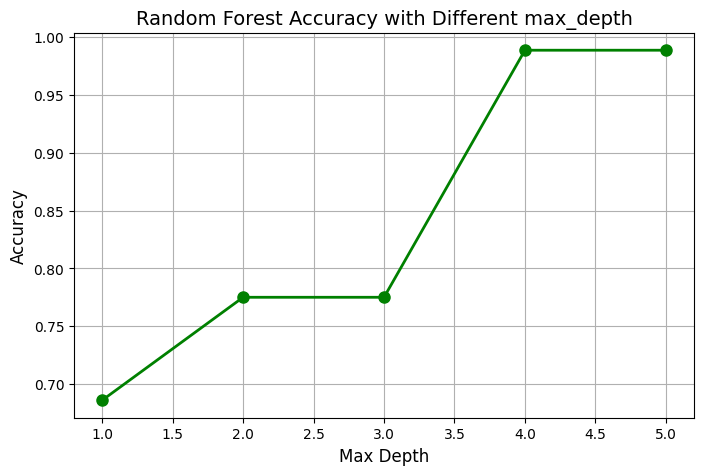

In [12]:
X_train, X_test, y_train, y_test = preprocess_data(data)

# Define a range of max_depth values to test
max_depth_list = [1, 2, 3, 4, 5]
accuracy_results = []

# Loop over different values of max_depth
for max_depth in max_depth_list:
    # Initialize the classifier with the current max_depth
    rf = MyRandomForestClassifier(n_estimators=10, max_depth=max_depth, min_samples_split=3)
    
    # Train the model
    rf.fit(X_train.values, y_train.values)
    
    # Make predictions
    y_pred_rf = rf.predict(X_test.values)
    
    # Calculate accuracy
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracy_results.append(accuracy_rf)

# Convert the results into a DataFrame for easier viewing
results_df = pd.DataFrame({
    'max_depth': max_depth_list,
    'Accuracy': accuracy_results
})

# Display the results
print(results_df)

# Plot the results for visual comparison
plt.figure(figsize=(8, 5))
plt.plot(max_depth_list, accuracy_results, marker='o', color='g', linestyle='-', linewidth=2, markersize=8)
plt.title("Random Forest Accuracy with Different max_depth", fontsize=14)
plt.xlabel("Max Depth", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True)
plt.show()

---

```bash
creating a flask application
```

Using the `Flask` library, along with `DaisyUI` **[5]** I was able to create a very simple frontend which levereges my random forest classifier. When a user visit my application, they are able to select 2 teams. My app will then pick a team by using by using my preprocessing method to predict on a head to head basis. This method utilizes `sklearn.preprocessing` `LabelEncoder` to encode each team into numeric values, which can be used as features for my model. 

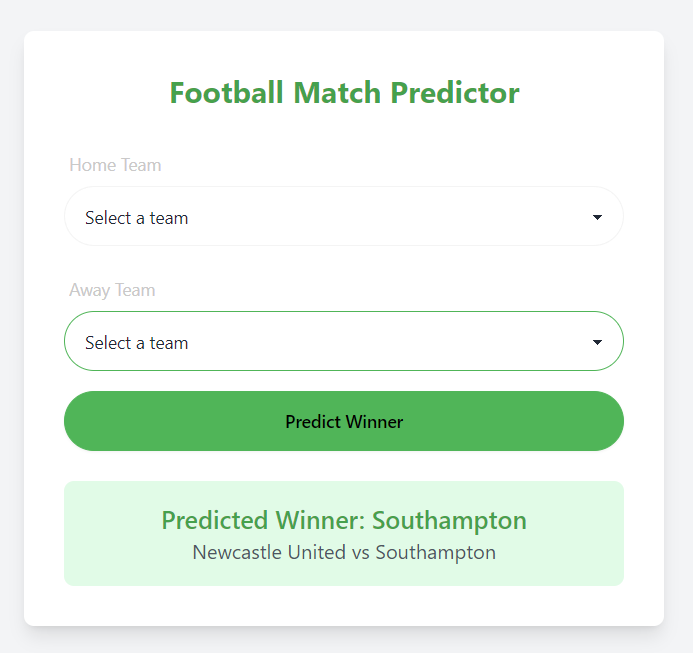

In [7]:
from IPython.display import Image

Image(filename="public/flaskapp.png")

---

```bash
summary & results
```

I learned quite a few things from this project, across different areas of computer science. Some of my takeaways from this project (I guess you could say "how tos"):
* how to use `Flask` to quickly set up web apps: I did not know you could render HTML so simply with a CSS framework and everything with a `Flask` server
* how to set up directories and import code across them with `.py/ipynb`
* how to create custom classifiers and use them to make predictions: previous projects have only ever involved using prebuilt classifiers
* how to create a pytest suite and integrate it into CI with Github actions, as well as a Python linter

This project also taught me how important it is to have working data preprocessing. The data has to be fine tuned to give good results, and creating a method from scratch for my specific use case was challenging. The concept of label encoding took a while to understand completely, and it took me some time to develop the correct data preprocessing method for my classification task. \
Future work would involve improving the Flask UI, supporting more insight into the model to be displayed on the frontend, further data scraping, and hosting of the `Flask` application

Sources

[1] [Ryan Kelly - What is xG in football & how is the statistic calculated?](https://www.goal.com/en/news/what-is-xg-football-how-statistic-calculated/h42z0iiv8mdg1ub10iisg1dju) \
[2] [Vikas Paruchuri - Web Scraping Football Matches From The EPL With Python](https://www.youtube.com/watch?v=Nt7WJa2iu0s&t=1s) \
[3] [UW Madison Computer Science Department - Random Forests](https://pages.cs.wisc.edu/~matthewb/pages/notes/pdf/ensembles/RandomForests.pdf) \
[4] [Stack Exchange - When should I use Gini Impurity](https://datascience.stackexchange.com/questions/10228/when-should-i-use-gini-impurity-as-opposed-to-information-gain-entropy) \
[5] [DaisyUI docs](https://daisyui.com/)

data from: [fbref.com](https://fbref.com/), scarped with help of **[2]**

*ai usage: ChatGPT was used to help debug and write comments on code, it also helped rebuild my preprocessing method.* \
*python libraries: sklearn, pandas, numpy, searborn, matplotlib* 



```bash
thank you!
```
